# Stochastic Optimal Growth Model -- Random Log Normal

This notebook solves the another stochastic version of the optimal growth model.

## Theory

The stochastic optimal growth model assumes the same setting as the deterministic growth model solved in the previous notebook. However, we now introduce uncertainty to the technology parameter $A_t$ by assuming that the realization of {$A_1, A_2, ...$} is i.i.d. and follows a log normal distribution with mean $\mu$ and variance $\sigma^2$, that is $logA \sim N(\mu, \sigma^2)$. 

To numerically solve the stochastic growth model, we can take $A_t$ as another state variable. The Bellman equation becomes

$$
V(k,A) = \max_{k'}
    \left\{
    u[(1 - \delta) \cdot k + A \cdot f(k) - k'] + \beta \mathbb E[{V(k', A')]}
    \right\}.\tag{1}
$$

Note that, unlike the previous notebook where $A_t$ follows a Markov Chain, here $\mathbb E[{V(k', A')]}$ does not depend on the $A$ since {$A_1, A_2, ...$} is i.i.d.

## Computation

In [1]:
import quantecon as qe
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from quantecon.optimize.scalar_maximization import brent_max
from interpolation import interp
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm

Again, we start by defining a class that specify parameters, utility and production functions. We also need to specify the state spaces for both $k$ and $A$. 

Unlike the deterministic case, the Bellman equation here involves an expectation operator which is difficult to evaluate. Therefore, we use Monte Carlo to compute the expression $\mathbb E[V(k', A')]$. That is, we use the approximation 

$$
\mathbb E[V(k', A')]  \approx \frac{1}{N} \sum_{i=1}^N V(k', A_i')
$$

where $N$ is the sample size of $A'$.

In [2]:
class StochasticOptimalGrowth:

    def __init__(self,
                 f,                
                 u,                
                 β = 0.8,           
                 δ = 1,
                 max_k = 2,
                 k_size = 500,  # Number of grids for k
                 μ = 1,
                 sigma = 0.1,
                 N = 50,  # Sample size of A for Monte Carlo
                 max_A = 30,
                 A_size = 500): # Number of grids for A:
        
        self.β, self.δ, self.f, self.u = β, δ, f, u 
        self.k_space = np.linspace(1e-5, max_k, k_size)    # Discretize the state space
        
        self.μ, self.sigma, self.max_A, self.A_size = μ, sigma, max_A, A_size
        self.A_space = np.linspace(1e-5, max_A, A_size)    # Discretize the state space

        self.N = N
        self.A_samples = np.exp(μ + sigma * np.random.randn(N)).reshape(N, 1)
        # Random draw of A from log normal

```operator``` is the same as the that of the deterministic case, except that we use Monte Carlo to compute the LHS of the Bellman equation, and that we need the realization of $A_t$ for optimal paths of $k$, $y$ and $c$.

In [3]:
def operator(sog):
    
    # Unpack the parameters that we specified in the class "StochasticOptimalGrowth"
    f, u, β, δ = sog.f, sog.u, sog.β, sog.δ
    k_space = sog.k_space
    
    μ, sigma, N, max_A, A_size = sog.μ, sog.sigma, sog.N, sog.max_A, sog.A_size
    A_space = sog.A_space
    A_samples = sog.A_samples
    N = sog.N

    # Objective Function -- LHS of the Bellman equation
    @jit
    def obj(new_k, v, old_k, A):
        val_func = lambda x: interp(k_space, A_space, v, x)
        x = np.concatenate((np.full((N, 1),new_k), A_samples), axis = 1)
        return u((1 - δ) * old_k + f(old_k) * A - new_k) + β * np.mean(val_func(x))  # Monte Carlo

    # Bellman Operator
    @jit
    def Bellman(v):
        new_v = np.empty_like(v)
        for i in range(len(k_space)):
            for j in range(len(A_space)):
                old_k = k_space[i]
                A = A_space[j]
                max_v = brent_max(obj, 1e-10, (1-δ) * old_k + f(old_k) * A, args=(v, old_k, A))[1]
                new_v[i,j] = max_v
        return new_v

    # Policy Function
    @jit
    def policy(v):
        p = np.empty_like(v)
        for i in range(len(k_space)):
            for j in range (len(A_space)):
                old_k = k_space[i]
                A = A_space[j]
                p_s = brent_max(obj, 1e-10, (1-δ) * old_k + f(old_k) * A, args=(v, old_k, A))[0]
                p[i,j] = p_s
        return p
    
    # A function that can obtain the optimal paths of k, y, c. 
    def time_path(k,t):
        continuous_policy = lambda k, A: interp(k_space, A_space, true_p_func, (k,A))
        # "true_p_func" is the true policy function -- we need to define it using this exact name later so that the
        # function can run
        
        # The realization of A_t
        A_path = np.exp(μ + sigma * np.random.randn(t + 1))
        
        k_path = [k]
        y_path = [f(k) * A_path[0]]
        c_path = []
        
        # Simulate k, y, c up to time t
        for i in range(t):
            new_k = continuous_policy(k, A_path[i])
            new_y = f(new_k) * A_path[i + 1]
            k_path.append(new_k)
            y_path.append(new_y)
            c_path.append((1-δ) * k + f(k) * A_path[i] - new_k)
            k = new_k
        
        return k_path, y_path, c_path

    return Bellman, policy, time_path

As what we did in previous notebooks, we take $f(k) = k^\alpha$, and $ u(c) = \dfrac {c^{1 - \gamma}}{1 - \gamma}$ for $\gamma \neq 1$ and $u(c) = log(c)$ for $\gamma = 1$.

In [4]:
α = 0.4
@jit
def f(k):
    return k**α

In [5]:
γ = 1
@jit
def u(c):
    if γ == 1:
        return np.log(c)
    else:
        return c**(1 - γ) / (1 - γ)

In [6]:
sog = StochasticOptimalGrowth(f=f, u=u)
Bellman, policy, time_path = operator(sog)

# This enables us to use functions "Bellman", "policy", "time_path" for the parameters and specific utility 
# and production functions we specified in the class "StochasticOptimalGrowth"

Again, we define a function ```iteration``` to iterate the value function until it converges or reaching the maxmimum iterations allowed. 

In [7]:
def iteration(sog, tol = 1e-4, max_iter = 1000):

    Bellman, policy, time_path = operator(sog)

    v = np.ones(len(sog.k_space) * len(sog.A_space)).reshape(len(sog.k_space), len(sog.A_space)) # initial guess
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_new = Bellman(v)
        error = np.max(np.abs(v - v_new))
        i += 1
        v = v_new

    if i == max_iter:
        print("Failed to converge!")

    return v_new

We obtain the true value function ```true_v_func``` by using the function ```iteration``` and plot it. 

In [8]:
true_v_func = iteration(sog)

The value function is now $ \mathscr{k} \times \mathscr{A} \to \mathbb R$ where $ \mathscr{k}$ and $ \mathscr{A}$ are the state spaces of $k$ and $A$ respectively. 

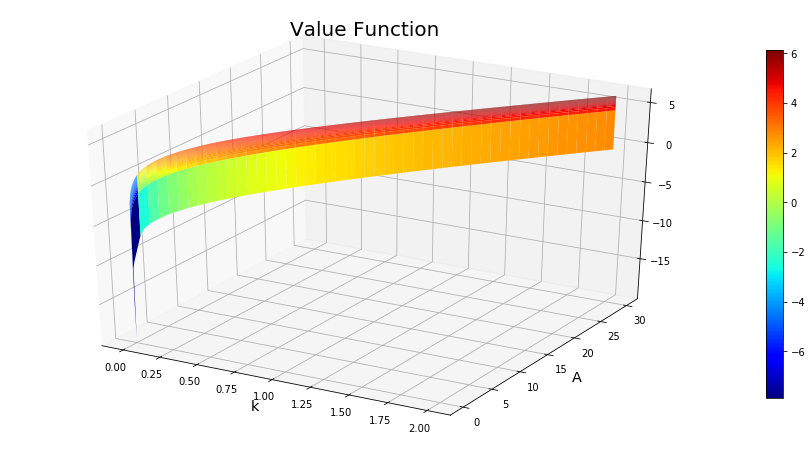

In [9]:
k_space, A_space = sog.k_space, sog.A_space

fig = plt.figure(figsize=(16, 8))
ax = fig.gca(projection='3d')
graph = ax.plot_surface(k_space, A_space, true_v_func, cmap = cm.jet)
fig.colorbar(graph, shrink = 0.8)
plt.xlabel('k', size = 'x-large')
plt.ylabel('A', size = 'x-large')
plt.title('Value Function', fontsize=20)
plt.show()

Obtain the policy function by ```policy``` and name it ```true_p_func```.

In [10]:
true_p_func = policy(true_v_func)

Finally, we can obtain the optimal paths of $c$, $y$, $k$ by ```time_path```. 

In [11]:
k_0 = 0.01
max_time = 40
k_p, y_p, c_p = time_path(k_0,max_time)

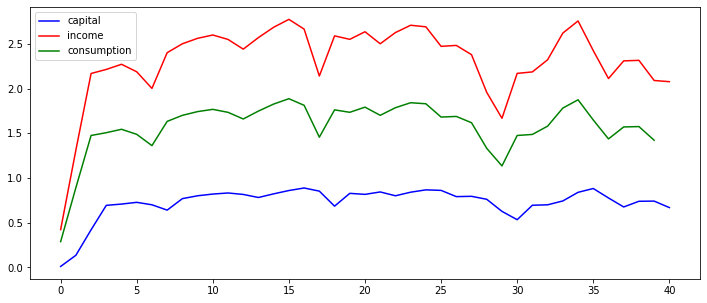

In [12]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(k_p,'b-', label='capital')
ax.plot(y_p, 'r-', label='income')
ax.plot(c_p, 'g-', label='consumption')

ax.legend()
plt.show()